In [1]:
# based on https://github.com/ShivamShrirao/diffusers/blob/main/examples/dreambooth/DreamBooth_Stable_Diffusion.ipynb

#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


In [2]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate==0.12.0 transformers ftfy bitsandbytes gradio natsort

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 25.3 MB/s 
     |████████████████████████████████| 18.7 MB 861 kB/s 
     |████████████████████████████████| 143 kB 34.7 MB/s 
     |████████████████████████████████| 5.5 MB 52.9 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 62.5 MB 1.2 MB/s 
     |████████████████████████████████| 11.6 MB 62.5 MB/s 
     |████████████████████████████████| 7.6 MB 55.6 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 272 kB 67.3 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 2.3 MB 68.4 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 106 kB 72.6 MB/s 
     |███████

In [3]:
%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl
# These were compiled on Tesla T4, should also work on P100, thanks to https://github.com/metrolobo

# If precompiled wheels don't work, install it with the following command. It will take around 40 minutes to compile.
# %pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

     |████████████████████████████████| 102.9 MB 97 kB/s 


In [4]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/mmdd111" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

[*] Weights will be saved at /content/stable_diffusion_weights/mmdd111


In [5]:
!mkdir training_images
!mkdir training_images/dog

In [6]:
#@markdown Hugging Face Login
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [7]:
!wget https://github.com/xuduo35/UniTune/raw/main/training_images/dog/dog1.png -O ./training_images/dog/dog1.png

--2022-11-14 11:15:33--  https://github.com/xuduo35/UniTune/raw/main/training_images/dog/dog1.png
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xuduo35/UniTune/main/training_images/dog/dog1.png [following]
--2022-11-14 11:15:33--  https://raw.githubusercontent.com/xuduo35/UniTune/main/training_images/dog/dog1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138211 (135K) [image/png]
Saving to: ‘./training_images/dog/dog1.png’

./training_images/d 100%[===================>] 134.97K  --.-KB/s    in 0.003s  

2022-11-14 11:15:33 (41.8 MB/s) - ‘./training_images/dog/dog1.png’ saved [138211/1382

In [8]:
!wget https://raw.githubusercontent.com/xuduo35/UniTune/main/train_unitune_colab.py -O train_unitune_colab.py

--2022-11-14 11:15:37--  https://raw.githubusercontent.com/xuduo35/UniTune/main/train_unitune_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34010 (33K) [text/plain]
Saving to: ‘train_unitune_colab.py’

train_unitune_colab 100%[===================>]  33.21K  --.-KB/s    in 0s      

2022-11-14 11:15:37 (153 MB/s) - ‘train_unitune_colab.py’ saved [34010/34010]



In [9]:
!accelerate launch train_unitune_colab.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --save_interval=10000 \
  --save_sample_prompt="mmdd111" \
  --instance_prompt="mmdd111" \
  --instance_data_dir="./training_images/dog" \
  --max_train_steps 100

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--num_cpu_threads_per_process` was set to `1` to improve out-of-box performance
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Downloading: 100% 1.06M/1.06M [00:00<00:00, 30.4MB/s]
Downloading: 100% 525k/525k [00:00<00:00, 25.0MB/s]
Downloading: 100% 472/472 [00:00<00:00, 407kB/s]
Downloading: 100% 822/822 [00:00<00:00, 738kB/s]
Downloading: 100% 636/636 [00:00<00:00, 637kB/s]
Downloading: 100% 246M/246M [00:03<00:00, 70.8MB/s]
Downloading: 100% 167M/167M [00:02<00:00, 74.3MB/s]
Downloading: 100% 609/609 [00:00<00:00, 531kB/s]
Downloading: 100% 1.72G/1.72G [00:24<00:00, 71.0MB/s]
Downloading: 100% 806/806 [00:00<00:00, 751kB/s]
Downloading: 100% 308/308 [00:00<00:00, 278kB/s]
Caching latents: 100% 1/1 

In [10]:
#@markdown Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" #@param {type:"string"}
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/stable_diffusion_weights/mmdd111/100


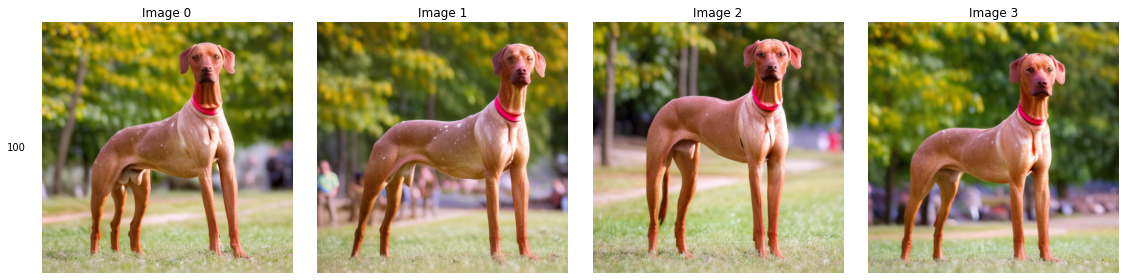

In [11]:
#@markdown Run to generate a grid of preview images from the last saved weights.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)

In [12]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /content/stable_diffusion_weights/mmdd111/100/model.ckpt


In [13]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")

g_cuda = None

In [14]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 1337 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/50 [00:00<?, ?it/s]

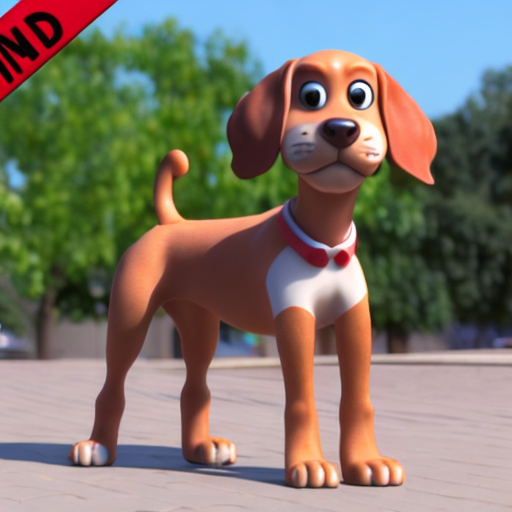

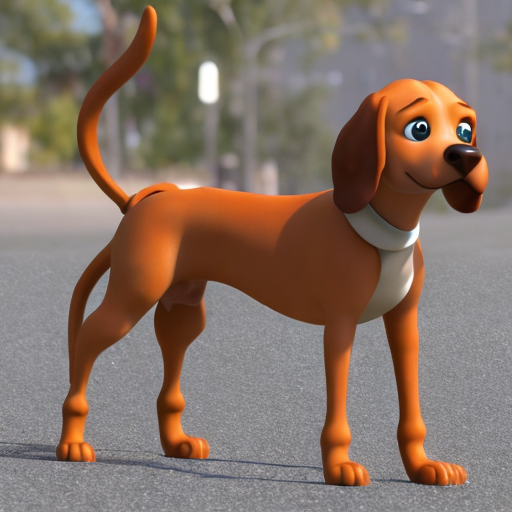

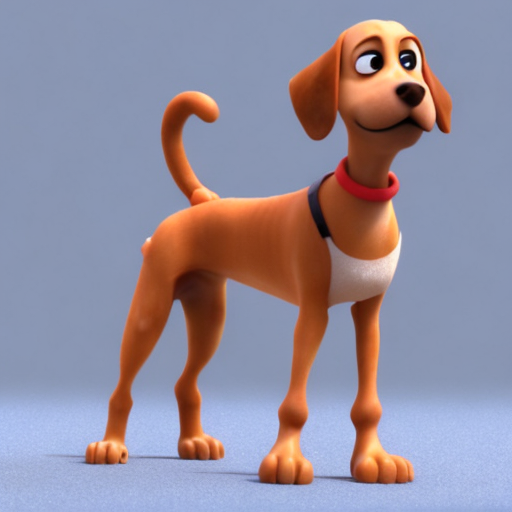

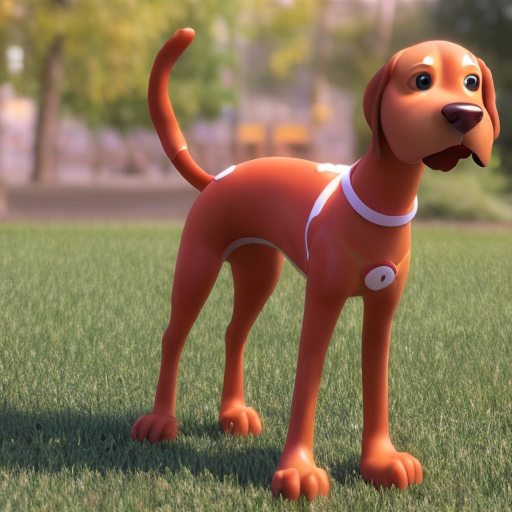

In [17]:
#@title Run for generating images.

prompt = "mmdd111 dog in pixar 3d rendering style" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)